In [1]:
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
def nuevoNodoInicioTrasCaida(caminosMinimos, NodoInicioActual, NodoTerminoActual, tiempoTranscurrido):
    listaNodos=caminosMinimos[(NodoInicioActual,NodoTerminoActual)][0]
    listaTiemposAcumulados = caminosMinimos[(NodoInicioActual,NodoTerminoActual)][1]
    for i in range(0,len(listaNodos)):
        if tiempoTranscurrido <= listaTiemposAcumulados[i]:
            if i == 0:
                return NodoInicioActual
            else:
                if tiempoTranscurrido <= (listaTiemposAcumulados[i-1]+listaTiemposAcumulados[i])/2:
                    return listaNodos[i-1]
                else:
                    return listaNodos[i]
    return NodoTerminoActual



In [3]:
dfPitloc = pd.read_excel('Pitloc.xlsx')
dfPitloc.head()
dfPitloc.drop([i for i in dfPitloc.columns if i not in ['id', 'xloc','yloc', 'zloc']], axis=1, inplace = True)
dfPitloc.head()

,id,xloc,yloc,zloc
0,BOT,28497,82023,4500.000000
1,C-ENTRENAMIENTO,28419,79699,4603.000000
2,CAPELLA,0,76000,4837.200195
3,CO01,38394,79907,4365.100098
4,CS01,38309,79873,4367.200195


In [4]:
Coordenadas = {}
xyznodos = {}

for index, row in dfPitloc.iterrows():
    xyznodos[row[0]] = {'xloc': row[1], 'yloc': row[2], 'zloc': row[3]}
    Coordenadas[row[0]] = {'pos':(row[1], row[2]) }


In [13]:
df = pd.read_excel('Travel.xlsx')
df.columns = df.iloc[0]
df.drop(0, inplace = True)
df

,ddbkey,id,locstart,locend,xgraph,ygraph,dist,timeempty,timeloaded,closed,factor,street,resist
1,1411328,000EBC18,C-ENTRENAMIENTO,NR216,<array>,<array>,477,52,94,0,100,NaN,0
2,1411482,000EBDCC,CO01,NU58,<array>,<array>,46,10,23,0,100,NaN,0
3,1411636,000EBEA6,CS01,NU41,<array>,<array>,78,14,13,0,100,NaN,0
4,1411790,000EBF80,CS03,NR347,<array>,<array>,58,10,12,0,100,NaN,0
5,1411944,000EBF80,CS03,NR353,<array>,<array>,48,11,15,0,100,NaN,0
6,1412098,000EC05A,ESTAC 4600,NR231,<array>,<array>,290,46,75,0,100,NaN,0
7,1412252,000EC49C,NAVE01,TALLER ROSARIO,<array>,<array>,57,10,8,0,100,NaN,0
8,1412406,000EC576,NAVE02,TALLER ROSARIO,<array>,<array>,49,6,7,0,100,NaN,0
9,1412560,000EC650,NAVE03,TALLER ROSARIO,<array>,<array>,43,6,6,0,100,NaN,0
10,1412714,000EC72A,NAVE04,TALLER ROSARIO,<array>,<array>,36,3,5,0,100,NaN,0


In [6]:
Y = []
DX = []
DY = []
DZ = []
for index, row in df.iterrows():
    ni = row['locstart']
    nt = row['locend']
    deltaX = abs(xyznodos[ni]['xloc']-xyznodos[nt]['xloc'])
    deltaY = abs(xyznodos[ni]['yloc']-xyznodos[nt]['yloc'])
    deltaZ = xyznodos[ni]['zloc']-xyznodos[nt]['zloc']
    DX.append(deltaX)
    DY.append(deltaY)
    DZ.append(deltaZ)
    Y.append(deltaZ/((deltaX**2+deltaY**2)**(1/2))*100)
    #print('    deltaX: {}'.format(deltaX))
    #print('    deltaY: {}'.format(deltaY))
    #print('    deltaZ: {}'.format(deltaZ))
    #print('    Pendiente:  {}'.format(deltaZ/((deltaX**2+deltaY**2)**(1/2))*100))
    
dfCoordenadas = pd.DataFrame(list(zip(Y, DX, DY, DZ)), columns =['Y', 'Delta X', 'Delta Y', 'Delta Z'])
dfCoordenadas.head()

#Y = dfCoordenadas['Y']
#X = dfCoordenadas[['Delta X', 'Delta Y', 'Delta Z']]

y = pd.DataFrame(dfCoordenadas['Y'])
X = pd.DataFrame(dfCoordenadas[['Delta X', 'Delta Y', 'Delta Z']])

X_train, X_test, y_train, y_test = train_test_split(X, Y)

model = LinearRegression()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print('Coeficientes: {}'.format(model.coef_))
print(score)
#scores = []
#kfold = KFold(n_splits=3, shuffle=True, random_state=42)
#for i, (train, test) in enumerate(kfold.split(X, y)):
#    model.fit(X.iloc[train,:], y.iloc[train,:])
#    score = model.score(X.iloc[test,:], y.iloc[test,:])
#    print('Coeficientes: {}'.format(model.coef_))
#    scores.append(score)


myvals = np.array([100, 100, 1]).reshape(1, -1)
print('Predicción: {}'.format(model.predict(myvals)))

Coeficientes: [-4.10219999e-04  3.06201826e-04  3.30603195e-01]
0.7382989892779759
Predicción: [0.33849191]


In [7]:
Arcos = []
for index, row in df.iterrows():
    Arcos.append([row[2], row[3], row[7], row[8], row[9], row[6]])
print(len(Arcos))

1388


In [8]:
%matplotlib notebook
G = nx.DiGraph()
contar = 0
for edge in Arcos:
    if edge[4] == 0:
        #print(edge[0], edge[1])
        G.add_edge(edge[0], edge[1], time_empty = edge[2], time_loaded = edge[3], color = 'b')
    else:
        contar +=1
        #print(edge[0], edge[1])
        G.add_edge(edge[0], edge[1], time_empty = edge[2], time_loaded = edge[3], color = 'r')
'-----------------------------------------------------------------------------------------------------'
SCC = [len(i) for i in nx.strongly_connected_components(G)]
'-----------------------------------------------------------------------------------------------------'
nx.is_strongly_connected(G)
nx.set_node_attributes(G, Coordenadas)
Nodos = list(G.nodes())
colors = [G[u][v]['color'] for u,v in G.edges]
print("Arcos cerrados: {}".format(contar))
print("Cantidad de nodos: {}".format(len(Nodos)))

Arcos cerrados: 183
Cantidad de nodos: 638


In [9]:
predecessors, distance = nx.floyd_warshall_predecessor_and_distance(G, weight='time_empty')
predecessors_loaded, distance_loaded = nx.floyd_warshall_predecessor_and_distance(G, weight='time_loaded')

<IPython.core.display.Javascript object>


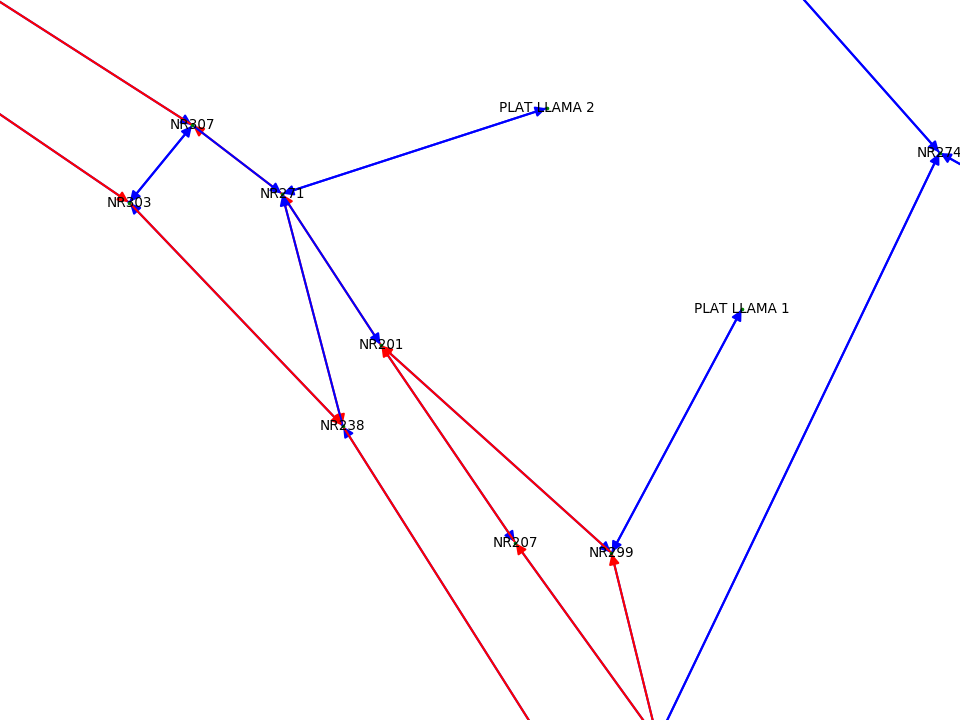

In [12]:
%matplotlib notebook
nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=True, font_size = 6.5,node_size=0.5, node_color = 'g',edge_color = colors, weight = 'time_loaded')

In [11]:
SCC = [len(i) for i in nx.strongly_connected_components(G)]
print(SCC)
largest = max(nx.strongly_connected_components(G), key=len)


[638]


<IPython.core.display.Javascript object>


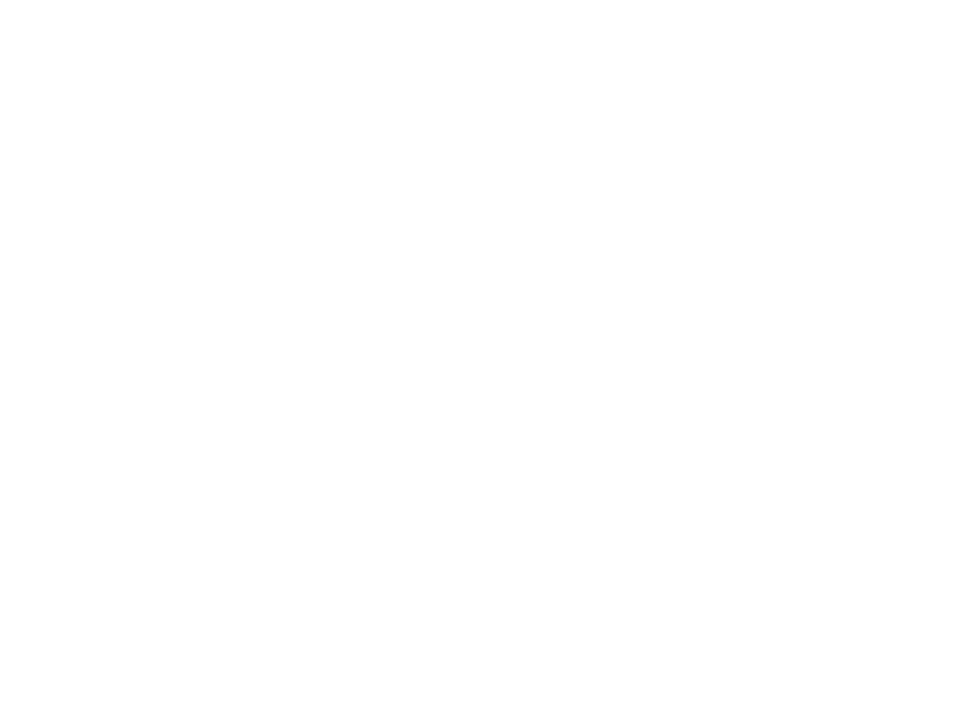

In [12]:
%matplotlib notebook
nombres = [i for i in range(len(Arcos))]
x_coords = [arco[5] for arco in Arcos]
y_coords = [arco[3]/60 for arco in Arcos]
for i, nombre in enumerate(nombres):
    x = x_coords[i]
    y = y_coords[i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x, y, nombre, fontsize= 6)
plt.title("Time loaded vs Distance")
plt.xlabel('Distancia (m)')
plt.ylabel('Tiempo (minutos)')
plt.show()   

<IPython.core.display.Javascript object>


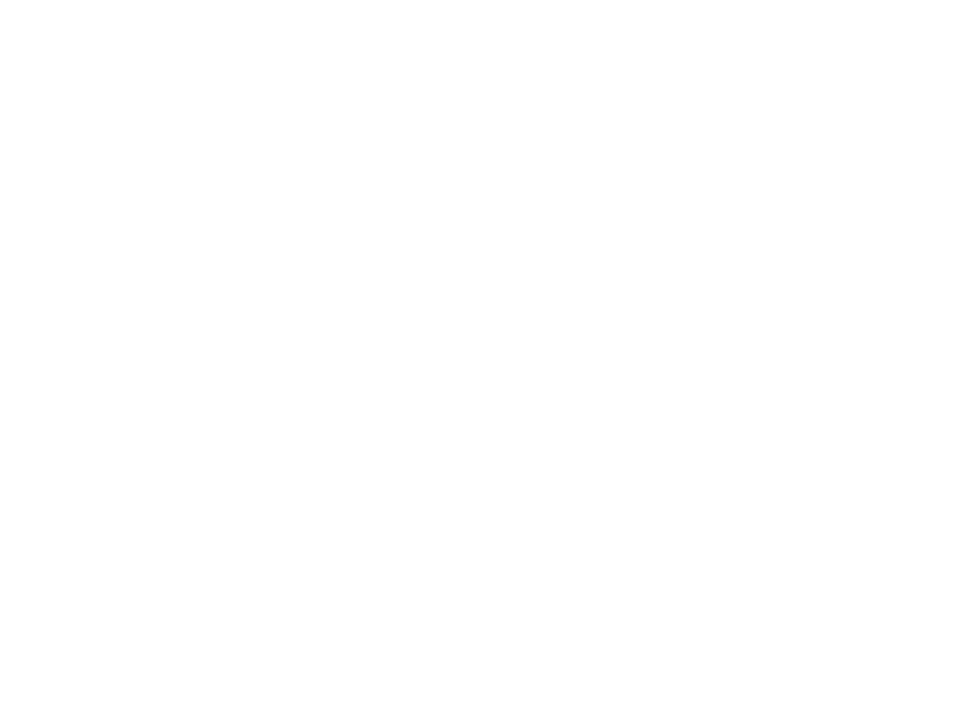

In [13]:
%matplotlib notebook
nombres = [i for i in range(len(Arcos))]
x_coords = [arco[5] for arco in Arcos]
y_coords = [arco[2]/60 for arco in Arcos]

for i, nombre in enumerate(nombres):
    x = x_coords[i]
    y = y_coords[i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x, y, nombre, fontsize = 6)
plt.title("Time empty vs Distance")
plt.xlabel('Distancia (m)')
plt.ylabel('Tiempo (minutos)')
plt.show()   

<IPython.core.display.Javascript object>


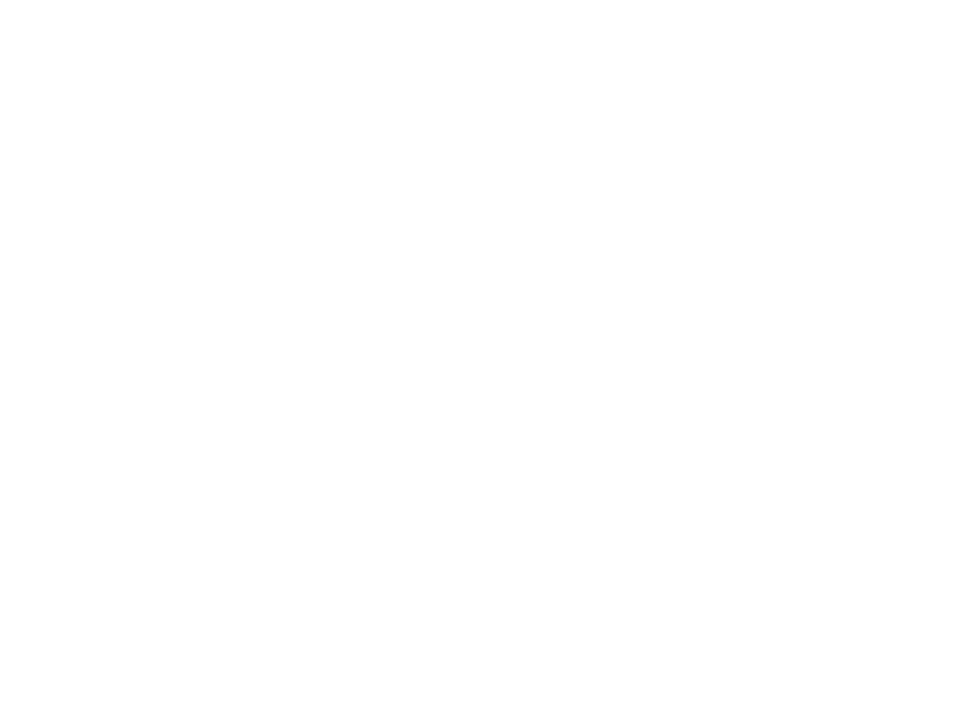

In [14]:
%matplotlib notebook
df['timeempty'].plot.hist(bins=300, alpha=0.5)

<IPython.core.display.Javascript object>


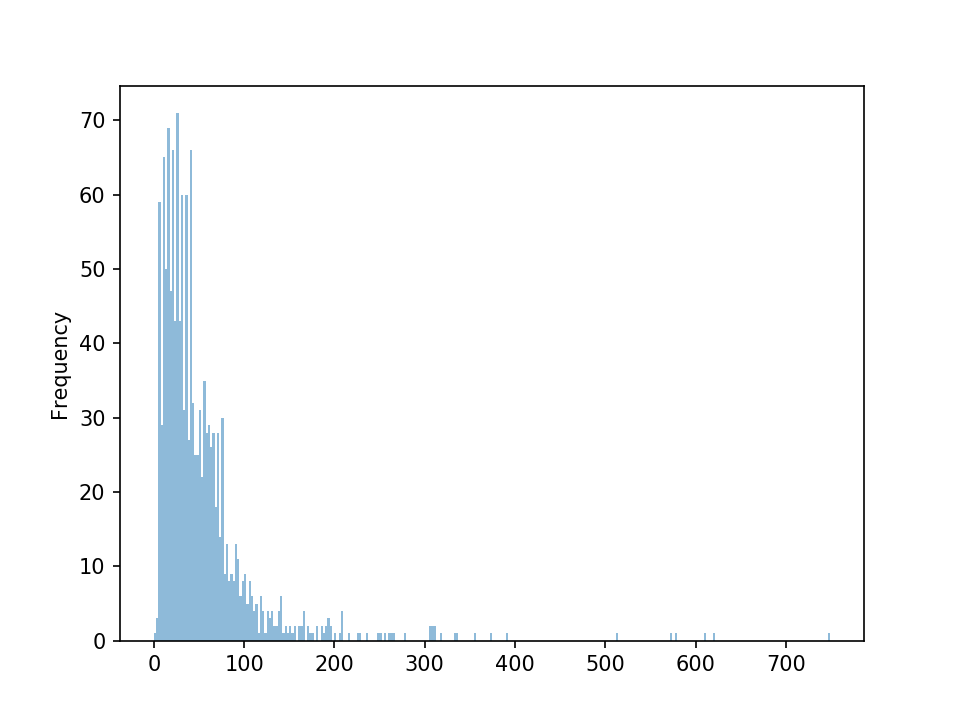

In [15]:
%matplotlib notebook
df['timeloaded'].plot.hist(bins=300, alpha=0.5)

In [16]:
caminosMinimosYTiemposAcumulados = {}
for nodoInicio in Nodos:
    for nodoTermino in Nodos:
        camino = nx.reconstruct_path(nodoInicio,nodoTermino,predecessors)
        tiempos = []
        tiempoAcumulado = 0
        tiempos.append(tiempoAcumulado)
        for i in range(0,len(camino)-1):
            tiempoAcumulado += distance[camino[i]][camino[i+1]]
            tiempos.append(tiempoAcumulado)
        caminosMinimosYTiemposAcumulados[(nodoInicio,nodoTermino)] = (camino,tiempos)

In [29]:
#print(nx.shortest_path_length(G, source='CS03', target='NR353', weight='time_empty', method='dijkstra'))
#print(nx.shortest_path_length(G, source='NR353', target='NR311', weight='time_empty', method='dijkstra'))
#print(nx.shortest_path_length(G, source='NR311', target='RS1-STOCKCR04/SAL', weight='time_empty', method='dijkstra'))
#print(nx.shortest_path(G, source='CS03', target='RS1-STOCKCR04/SAL', weight='time_empty', method='dijkstra'))
#list(G.neighbors('RS1-STOCKCR04/SAL'))
#G.nodes()

print(caminosMinimosYTiemposAcumulados[('CS03', 'RS1-STOCKCR04/SAL')])
nuevoNodoInicioTrasCaida(caminosMinimosYTiemposAcumulados, 'CS03', 'RS1-STOCKCR04/SAL', 23)

(['CS03', 'NR353', 'NR311', 'RS1-STOCKCR04/SAL'], [0, 11, 16, 28])


'RS1-STOCKCR04/SAL'